# Data streaming

## Task 1. Sampling

Group 97

Estimate the distribution over the other IP-address, what are the 10 most frequent values? Write code for RESERVIOR sampling, using it to estimate the distribution in one pass (no need to actually stream the data, you may store it in memeory, or run every file separately, but do store and load the intermediate results). Use a range of reservoir sizes. What are the 10 most frequent IP-addresses and their frequencies when sampled? Use the theory to explain any approximation errors you observe.

Reference: "An empirical comparison of botnet detection methods" Sebastian Garcia, Martin Grill, Jan Stiborek and Alejandro Zunino. Computers and Security Journal, Elsevier. 2014. Vol 45, pp 100-123. http://dx.doi.org/10.1016/j.cose.2014.05.011

In [1]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt

np.random.seed(42)
random.seed(42)
%matplotlib inline

Here we use scenario 1 (CTU-Malware-Capture-Botnet-42) for the task. 

Per the documentaion for the dataset, the number of differnt types of flow on this scenario is:

| Total flows | Botnet flows | Normal flows | C&C flows | Background flows |
|-------------|--------------|--------------|-----------|------------------|
| 2,824,636   | 1.41%        | 1.07%        | 0.03%     | 97.47%           |

The infected IP address is ***147.32.84.165***.

In [2]:
# define filepath for scenario 1 dataset
filepath = './data/capture20110811.pcap.netflow.labeled'

# read data from the file
f = open(filepath, 'r')
lines = f.readlines()
f.close()
data = lines[1:] # drop the header

In [3]:
def preprocessing(data):
    '''data preprocessing
    Input
    -----
    string of a data flow
    
    Return
    ------
    ip_address and label
    '''
    s = data.split('\t')
    s = [x for x in s if x] # remove empty elements
    # modify data type
    o = np.array([s[3].split(':')[0], #ScrAddr
                  s[5].split(':')[0], #DstAddr
                  s[11].rstrip('\n').rstrip() #Label
                 ])
    return o

## Reservoir sampling

In [4]:
print('The total number of stream data is {}.'.format(len(data)))

The total number of stream data is 6351188.


In [5]:
INFECTED_HOST = '147.32.84.165'

def reservior_sampling(k = 60000):
    '''sampling through a reservior of size k
    Parameter
    ---------
    k : reservior size
    
    Return
    ------
    top10 : the top 10 most frequent ip_address and freq count
    pp : proportion of reservior size to stream size
    '''
    START = time.time()
    
    reservior = list(map(preprocessing, data[:k]))
    for i in range(k+1, len(data)):
        # for pi, randomly replace j-th data in the reservior with i-th data
        if np.random.random() < k/i: # probability pi=k/i
            j = int(np.random.randint(0, k, 1))
            reservior[j] = preprocessing(data[i])
    df = pd.DataFrame(reservior, columns=['ScrAddr', 'DstAddr', 'Label'])
    
    # get the top10 most frequent ip and their frequencies
    ips = df.loc[df['Label'] == 'Botnet']
    infected_ips = ips.drop(columns=['Label']).values.reshape(-1) # flaten the array
    infected_ips = np.delete(infected_ips, np.where(infected_ips == INFECTED_HOST))
    count = np.unique(infected_ips, return_counts=True)
    count = pd.DataFrame({'ip' : count[0],
                          'freq' : count[1]})
    top10 = count.sort_values('freq', ascending=False).head(10)
    pp = np.round(k/len(data), 3) # proportion of reservior size to stream size
    
    END = time.time()
    return top10, pp, END - START

### Different reservior sizes

===== reservior sampling time: 2.81 sec =====


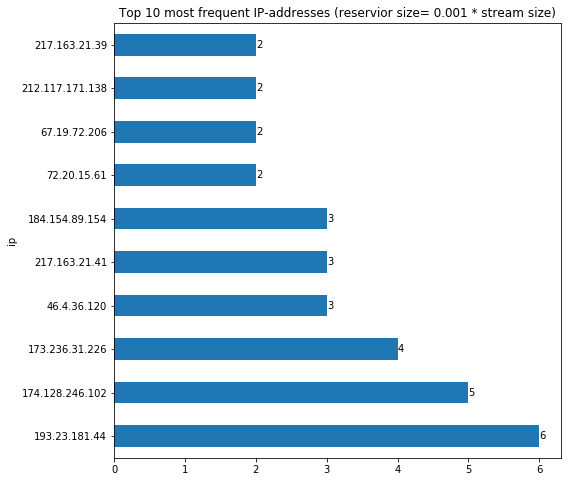

In [6]:
ips, pp, exe_time = reservior_sampling(6350) # reservior size = 6350
print('===== reservior sampling time: {0:0.2f} sec ====='.format(exe_time))

ax = ips.plot(x='ip', y='freq', kind='barh', legend=False, figsize=(8,8),
              title='Top 10 most frequent IP-addresses (reservior size= %0.3f * stream size)' % pp)


# add freq values to the barplot
for i, v in enumerate(ips.values):
    ax.text(v[1], i, str(v[1]), va='center')

# book keeping
ips.freq = ips.freq.apply(lambda x: x/pp)
ips_top10 = ips.copy()
exe_times = np.array([exe_time])

===== reservior sampling time: 4.54 sec =====


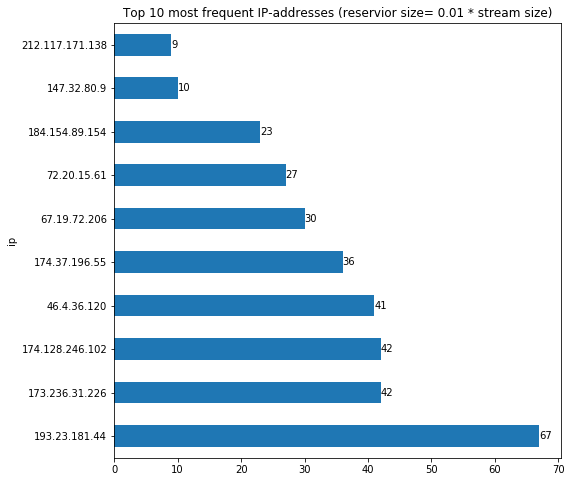

In [7]:
ips, pp, exe_time = reservior_sampling(63500) # reservior size = 63,500
print('===== reservior sampling time: {0:0.2f} sec ====='.format(exe_time))

ax = ips.plot(x='ip', y='freq', kind='barh', legend=False, figsize=(8,8),
              title='Top 10 most frequent IP-addresses (reservior size= %0.2f * stream size)' % (pp))

# add freq values to the barplot
for i, v in enumerate(ips.values):
    ax.text(v[1], i, str(v[1]), va='center')

# book keeping
ips.freq = ips.freq.apply(lambda x: x/pp)
ips_top10 = pd.merge(ips_top10, ips, how='outer', on='ip')
exe_times = np.append(exe_times, exe_time)

===== reservior sampling time: 14.57 sec =====


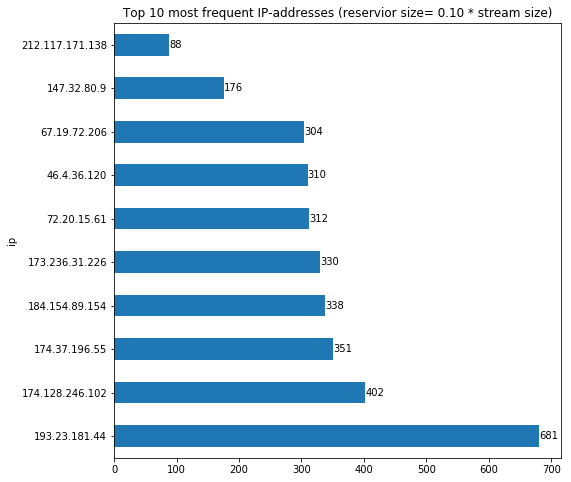

In [8]:
ips, pp, exe_time = reservior_sampling(635000) # reservior size = 635,000
print('===== reservior sampling time: {0:0.2f} sec ====='.format(exe_time))

ax = ips.plot(x='ip', y='freq', kind='barh', legend=False, figsize=(8,8),
              title='Top 10 most frequent IP-addresses (reservior size= %0.2f * stream size)' % (pp))

# add freq values to the barplot
for i, v in enumerate(ips.values):
    ax.text(v[1], i, str(v[1]), va='center')

# book keeping
ips.freq = ips.freq.apply(lambda x: x/pp)
ips_top10 = pd.merge(ips_top10, ips, how='outer', on='ip')
exe_times = np.append(exe_times, exe_time)

===== reservior sampling time: 22.30 sec =====


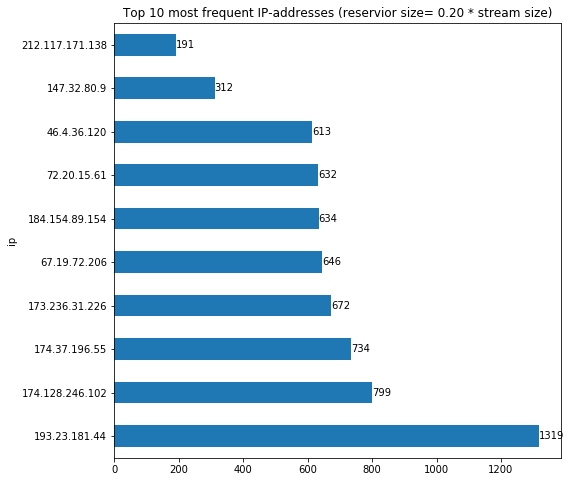

In [9]:
ips, pp, exe_time = reservior_sampling(1270000) # reservior size = 1,270,000
print('===== reservior sampling time: {0:0.2f} sec ====='.format(exe_time))

ax = ips.plot(x='ip', y='freq', kind='barh', legend=False, figsize=(8,8),
              title='Top 10 most frequent IP-addresses (reservior size= %0.2f * stream size)' % (pp))

# add freq values to the barplot
for i, v in enumerate(ips.values):
    ax.text(v[1], i, str(v[1]), va='center')

# book keeping
ips.freq = ips.freq.apply(lambda x: x/pp)
ips_top10 = pd.merge(ips_top10, ips, how='outer', on='ip')
exe_times = np.append(exe_times, exe_time)

## Reference: the real ranking

In [10]:
df = pd.DataFrame(list(map(preprocessing, data)), 
                  columns=['ScrAddr', 'DstAddr', 'Label'])
ips = df.loc[df['Label'] == 'Botnet']
infected_ips = ips.drop(columns=['Label']).values.reshape(-1) # flaten the array
infected_ips = np.delete(infected_ips, np.where(infected_ips == INFECTED_HOST))
count = np.unique(infected_ips, return_counts=True)
count = pd.DataFrame({'ip' : count[0],
                      'freq' : count[1]})
top10 = count.sort_values('freq', ascending=False).head(10)

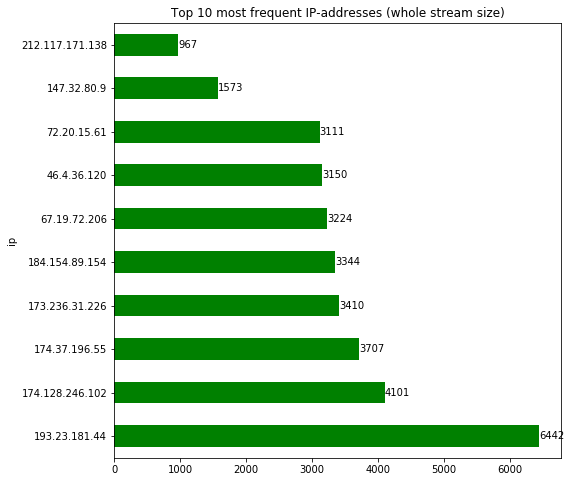

In [11]:
ax = top10.plot(x='ip', y='freq', kind='barh', legend=False, figsize=(8,8), color='g',
                title='Top 10 most frequent IP-addresses (whole stream size)')

# add freq values to the barplot
for i, v in enumerate(top10.values):
    ax.text(v[1], i, str(v[1]), va='center')

# book keeping
ips_top10 = pd.merge(ips_top10, top10, how='outer', on='ip')

## Comparison

In [13]:
ips_top10.fillna(value=0, inplace=True)
ips_top10.set_index('ip', inplace=True)
ips_top10.columns = ['.001', '.01', '.1', '.2', 'stream']

In [16]:
ips_top10

,.001,.01,.1,.2,stream
ip,,,,,
193.23.181.44,6000.0,6700.0,6810.0,6595.0,6442.0
174.128.246.102,5000.0,4200.0,4020.0,3995.0,4101.0
173.236.31.226,4000.0,4200.0,3300.0,3360.0,3410.0
46.4.36.120,3000.0,4100.0,3100.0,3065.0,3150.0
217.163.21.41,3000.0,0.0,0.0,0.0,0.0
184.154.89.154,3000.0,2300.0,3380.0,3170.0,3344.0
72.20.15.61,2000.0,2700.0,3120.0,3160.0,3111.0
67.19.72.206,2000.0,3000.0,3040.0,3230.0,3224.0
212.117.171.138,2000.0,900.0,880.0,955.0,967.0


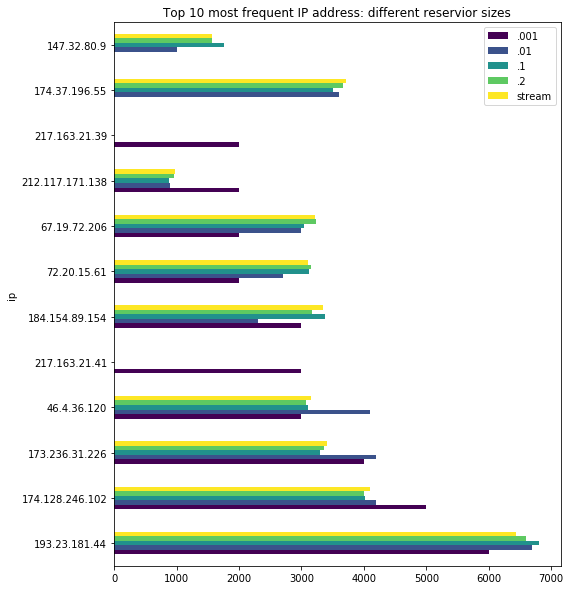

In [14]:
ips_top10.plot(kind='barh', figsize=(8, 10), colormap='viridis',
               title='Top 10 most frequent IP address: different reservior sizes')

Text(0, 0.5, 'Run time (sec)')

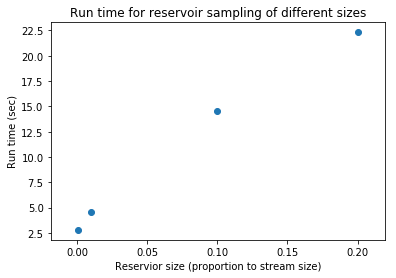

In [31]:
plt.scatter([float(x) for x in ips_top10.columns[:-1]], exe_times)
plt.title('Run time for reservoir sampling of different sizes')
plt.xlabel('Reservior size (proportion to stream size)')
plt.ylabel('Run time (sec)')